In [1]:
# Wawan Setiawan
# Universitas Sangga Buana

import cv2
from matplotlib import pyplot as plt
import imutils

In [3]:
import os
import sys
from pathlib import Path

from numpy import half
import torch

from models.common import DetectMultiBackend
from utils.datasets import LoadImages
from utils.general import (check_file, check_img_size, increment_path, non_max_suppression, scale_coords, clip_coords,
                          xywh2xyxy, xyxy2xywh)
from utils.plots import Annotator, colors
from utils.torch_utils import select_device, time_sync

In [4]:
half = False
augment=False
visualize=False
classes=None  
agnostic_nms=False 
save_img = True
save_crop = True
view_img = True
hide_labels = False
hide_conf = False

conf_thres=0.25  
iou_thres=0.45  
max_det=1000
line_thickness = 2

image_array = []

In [5]:
def save_one_box2(xyxy, im, file='image.jpg', gain=1.02, pad=0, square=False, BGR=False, save=True):
    # Save image crop as {file} with crop size multiple {gain} and {pad} pixels. Save and/or return crop
    xyxy = torch.tensor(xyxy).view(-1, 4)
    b = xyxy2xywh(xyxy)  # boxes
    if square:
        b[:, 2:] = b[:, 2:].max(1)[0].unsqueeze(1)  # attempt rectangle to square
    b[:, 2:] = b[:, 2:] * gain + pad  # box wh * gain + pad
    xyxy = xywh2xyxy(b).long()
    clip_coords(xyxy, im.shape)
    crop = im[int(xyxy[0, 1]):int(xyxy[0, 3]), int(xyxy[0, 0]):int(xyxy[0, 2]), ::(1 if BGR else -1)]
    return crop

In [6]:
# Load model
device = select_device('cpu')
weights = 'models/weights/best_platnomor.pt'

model = DetectMultiBackend(weights, device=device, dnn=False)
stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
imgsz = check_img_size(640, s=stride)  # check image size

YOLOv5  2021-12-8 torch 1.10.1+cpu CPU

Fusing layers... 
Model Summary: 213 layers, 7026307 parameters, 0 gradients


In [7]:
source =  'static/images/mobil2.jpeg'
source = check_file(source)
save_dir = Path('static/images/results')

# Half
half &= (pt or jit or engine) and device.type != 'cpu'
if pt or jit:
    model.model.half() if half else model.model.float()

dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
bs = 1  # batch_size
vid_path, vid_writer = [None] * bs, [None] * bs

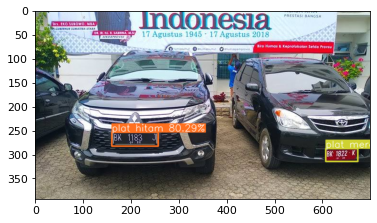

In [8]:
# Run inference
dt, seen = [0.0, 0.0, 0.0], 0
for path, im, im0s, vid_cap, s in dataset:
    t1 = time_sync()
    im = torch.from_numpy(im).to(device)
    im = im.half() if half else im.float()  
    im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None] 
    t2 = time_sync()
    dt[0] += t2 - t1

    # Inference
    visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
    pred = model(im, augment=augment, visualize=visualize)
    t3 = time_sync()
    dt[1] += t3 - t2

    # # NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    dt[2] += time_sync() - t3
    
    # Process predictions
    for i, det in enumerate(pred):  # per image
        seen += 1
        p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

        p = Path(p)  # to Path
        save_path = str(save_dir / p.name)  # im.jpg
        txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
        s += '%gx%g ' % im.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        imc = im0.copy() if save_crop else im0  # for save_crop
        annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            
        if len(det):
            # print(str(len(det)))
            
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(im.shape[2:], det[:, :4], im0.shape).round()

            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            # Write results
            for *xyxy, conf, cls in reversed(det):
                
                conf = conf*100
                if save_img or save_crop or view_img:  # Add bbox to image
                    c = int(cls)  # integer class
                    label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}%')
                    annotator.box_label(xyxy, label, color=colors(c, True))
                    if save_crop:
                        cropx = save_one_box2(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)
                        image_array.append(cropx)

        # Stream results
        im0 = annotator.result()
        
        if view_img:
            img = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)
            plt.imshow(img)

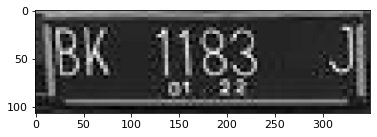

In [10]:
img = imutils.resize(image_array[0], width=350)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')